In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Examine nanopore properties

This notebook serves as a demonstration to examine the nanopore properties of a slice through a crystal. It shows how to use [scikit-image](https://scikit-image.org) [regionprops](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) to describe the size and shape of the pores.

<IPython.core.display.Javascript object>


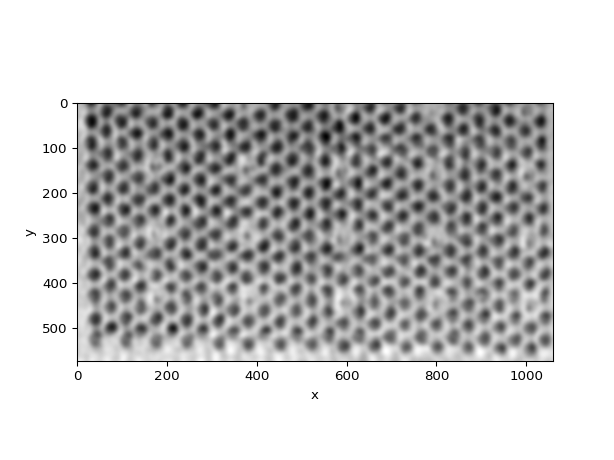

<AxesSubplot:xlabel='x', ylabel='y'>

In [51]:
from nanomesh import Plane
import numpy as np

plane_orig = Plane.load('x500.npy')

# rotate to make better use of space
plane_orig = plane_orig.apply(np.rot90)

# smooth image for better segmentation
plane = plane_orig.gaussian(sigma=5)
plane.show()

### Image segmentation

The image has a slight gradient from top to bottom, therefore we need to apply local thresholding. This has been described in [another notebook](https://nanomesh.readthedocs.io/en/latest/examples/How%20to%20segment%20image%20data%20using%20local%20thresholds.html).

<IPython.core.display.Javascript object>


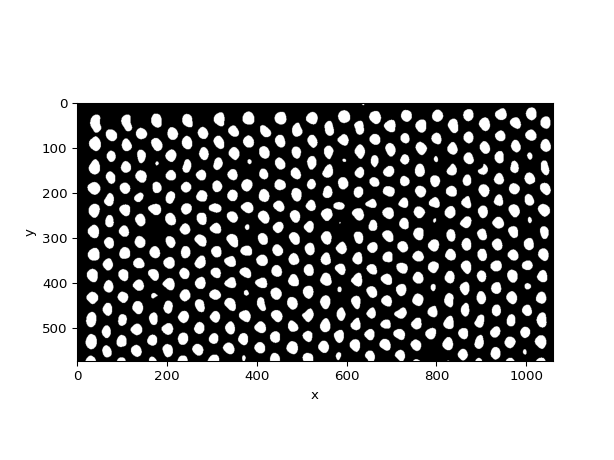

<AxesSubplot:xlabel='x', ylabel='y'>

In [34]:
from skimage.filters import threshold_local

offset = 150
block_size = 101

local_thresh = plane.threshold('local', block_size=block_size, offset=offset)
seg_local = plane.image > local_thresh.image

# invert contrast for object detection
seg = Plane(1-seg_local)
seg.show()

### Obtain regionprops

First the segmented image must be labeled. This means that all the objects in the above image are given a different label. The regionprops function then calculates the properties for each label. The original image is passed so that the contrast can be used for intensity calculations (if needed).

In [ ]:
from skimage import measure

labels = measure.label(seg.image)

props = measure.regionprops(labels, plane_orig.image)

Have a look at [the documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#regionprops) for the available properties.

Below are the properties we are interested in for the plots.

In [56]:
properties = ['area', 'eccentricity', 'perimeter', 'mean_intensity']

### Plots

The example below is adapted from the the [scikit-image gallery](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html). It interactively plots the selected objects on the source image, so that the properties of each can be explored. This example uses `plotly`.


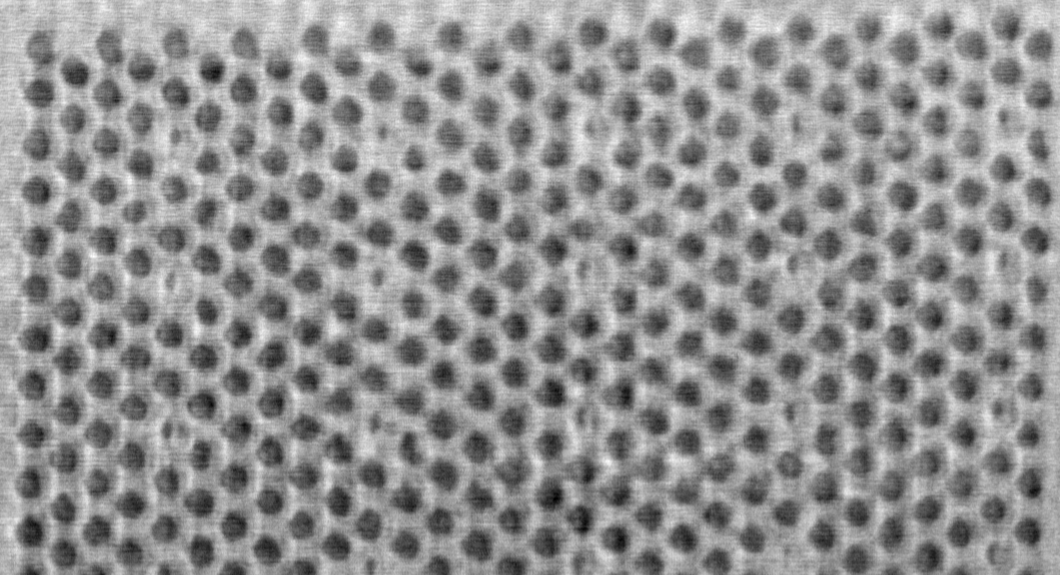

In [35]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

fig = px.imshow(plane_orig.image, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

Additionally, the propeties can be used to make some distribution plots.

<IPython.core.display.Javascript object>


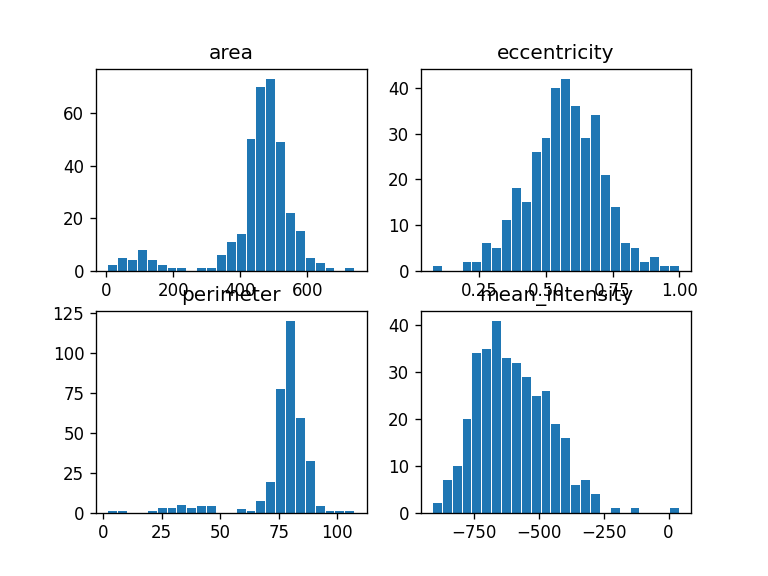

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

axes = axes.flatten()

for ax, prop_name in zip(axes, properties):
    data = [getattr(prop, prop_name) for prop in props]
    ax.hist(data, bins=25, rwidth=0.9)
    ax.set_title(prop_name)